In [1]:
# 最终画图选的参数：
# DG 10 3 10
# EG 20 3 15
# zebrafish 20 3 10

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from scipy.sparse import csr_matrix
import scvelo as scv
from torch.optim import SGD, Adam, Adagrad
from function import *

from utils import *
from g2g_model_Fisher import *


In [ ]:
data_path = f'data/'
path_path = "RC_path/"
figure_path="figure/cv_2/"
cmap = plt.colormaps['Spectral_r']
save = True

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
AnnData object with n_obs × n_vars = 3139 × 678
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'celltype', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_point

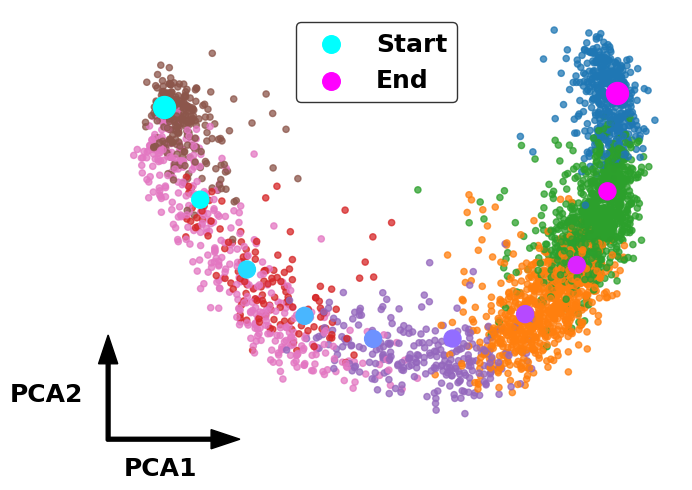

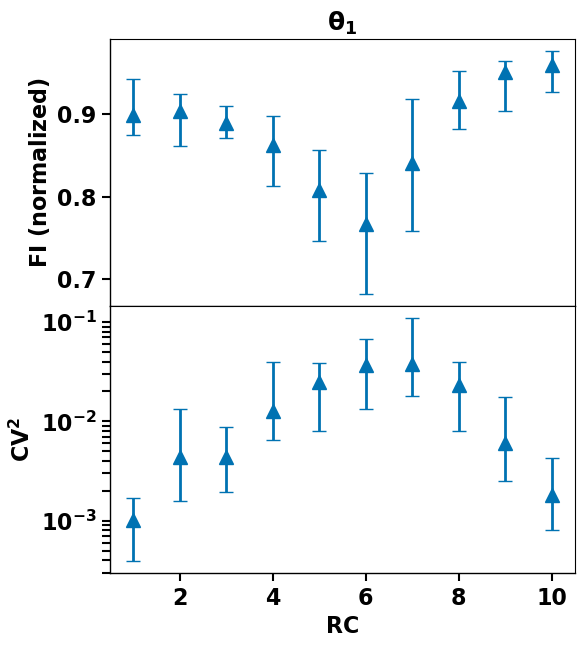

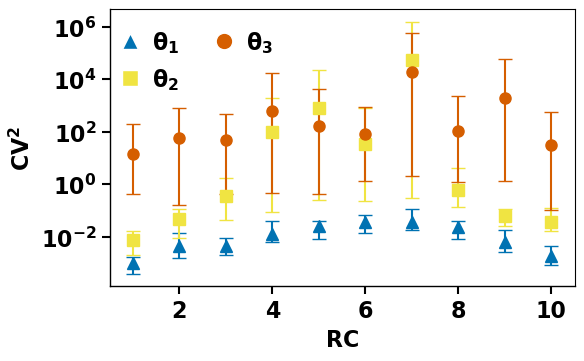

pca_svd_rc_mean_all:
[[[-6.37150288e+00 -3.87996745e+00  5.46523213e-01]
  [-6.51181555e+00 -3.85928369e+00 -2.70975549e-02]
  [-6.60028982e+00 -3.28549552e+00 -1.59180105e-01]
  [-6.82190561e+00 -2.91703534e+00 -5.89942694e-01]
  [-6.48651886e+00 -3.62839365e+00  1.26840442e-01]
  [-6.71176100e+00 -3.11691904e+00  1.77817568e-01]
  [-6.26101494e+00 -3.92527676e+00 -2.53473371e-01]
  [-6.93480635e+00 -2.61999536e+00 -1.07971802e-01]
  [-6.14979506e+00 -4.11405611e+00  5.21507442e-01]
  [-6.25663853e+00 -4.02118444e+00 -4.61350799e-01]
  [-6.07307196e+00 -4.29378843e+00 -1.56741664e-01]
  [-5.95360518e+00 -4.41218662e+00 -5.58769070e-02]
  [-6.47373676e+00 -3.70371485e+00  1.54261842e-01]
  [-5.95006466e+00 -4.42266035e+00 -3.42178911e-01]
  [-6.76324892e+00 -2.90113735e+00 -5.11746645e-01]
  [-6.14849901e+00 -4.07043648e+00  5.41649878e-01]
  [-6.12338734e+00 -4.14039946e+00  1.46998852e-01]
  [-6.06477833e+00 -4.08243561e+00 -3.80234897e-01]
  [-6.22080946e+00 -3.99536800e+00 -9.69411

In [ ]:
data_name = "DG_bin_ppt"

[pca_dim, k_rc, d_pca, nrc] = [50, 30, 2, 10]
[k_nei, K, L] = [10, 3, 10]

clusters_name = "ClusterName"
root_cluster = "RadialGlia"
loc_path_graph = 'upper left'
basis = "pca"

t_list = np.array(['RadialGlia','nIPC', 'Nbl1', 'Nbl2', 'ImmGranule1', 'ImmGranule2', 'Granule' ])
branch_name = t_list[-1]

adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)
adata = adata0.copy()
scv.pp.pca(adata, n_comps=pca_dim)
scv.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.moments(adata, n_pcs=pca_dim, n_neighbors=k_nei)
scv.tl.velocity(adata)
print(adata)

for nrc in [10]:
    # average_path = np.load(path_path + f'{data_name}_{branch_name}_P2M_rc_nrc_{nrc}_dpca_{d_pca}.npy') 
    average_path = np.load(path_path + f'{data_name}_P2M_rc_nrc_{nrc}_dpca_{d_pca}.npy') 
    cell_arr, nearest_cell = find_nearest_indices_voronoi(adata = adata, path0= average_path, rc_distance= "X_pca", n_nei=k_rc, dim_n=d_pca)            
    average_path[:,0] = -average_path[:,0]


    # fig = sc.pl.embedding(
    #     adata,
    #     # color=[clusters_name, "paga"],
    #     color=[clusters_name],
    #     basis="pca",
    #     color_map=cmap,
    #     return_fig=True
    # )

    X_pca = adata.obsm['X_pca']
    row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
    col = adata.uns['neighbors']['indices'].flatten()
    w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
    adj_val = np.ones(col.shape)
    A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
    A = A_mat
    W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
    dc=np.mean(w_val)
    cell_nei=adata.uns['neighbors']['indices']
    nei_w=[]
    rho_arr=[]
    for ni in adata.uns['neighbors']['indices']:
        dij=np.array([np.linalg.norm(X_pca[int(ni[0]),:]-X_pca[int(i),:]) for i in ni[1:]])
        rho=np.sum(np.exp(-dij**2/dc**2))
        nei_w.append(np.exp(-dij**2/dc**2)/np.sum(np.exp(-dij**2/dc**2)))
        rho_arr.append(rho)
        
    rho_arr=np.array(rho_arr)/np.amax(rho_arr)
    nei_w=np.array(nei_w)
    nei_w=np.hstack((np.ones((nei_w.shape[0],1)),nei_w))/2

    def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
        X_s=X_val.copy()
        for ci in range(len(X_val)):
            X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
        return X_s

    if basis == "umap":
        X_umap = adata.obsm['X_umap']
        X_plt = X_umap[:,0]
        Y_plt = X_umap[:,1]
        X_min = np.min(X_plt)
        X_max = np.max(X_plt)
        Y_min = np.min(Y_plt)
        Y_max = np.max(Y_plt)
        X_len = (X_max-X_min)/5
        Y_len = (Y_max-Y_min)/5
        wid = min(X_len,Y_len)/30
        X_ori = X_min-wid*10
        Y_ori = Y_min-wid*10
    elif basis == "pca":
        X_umap = adata.obsm['X_pca'][:, :2]
        X_plt = X_umap[:,0]
        Y_plt = X_umap[:,1]
        X_min = np.min(X_plt)
        X_max = np.max(X_plt)
        Y_min = np.min(Y_plt)
        Y_max = np.max(Y_plt)
        X_len = (X_max-X_min)/5
        Y_len = (Y_max-Y_min)/5
        wid = min(X_len,Y_len)/30
        X_ori = X_min-wid*10
        Y_ori = Y_min-wid*10

    X = torch.tensor(adata.layers['Ms'], dtype=torch.float32) 
    Encoder_path = "encoder/"
    # for pca in [X_pca, eigengene, hotspot]:

    model_path = Encoder_path + data_name+' '+str([k_nei,K,L])+'/'
    # eigengene = np.load(f"{model_path}cell_eigen_X.npy")
    # hotspot = np.load(f"{model_path}cell_hs_X.npy")
    model_name = f"{model_path}encoder.pt"
    model = torch.load(f'{model_name}')
    mu, sigma = model(torch.tensor(X))
    mu_learned = mu.detach().numpy()

    sigma_learned = sigma.detach().numpy()
    Fisher_g=np.zeros((X.shape[0],L*2,L*2))
    for i in range(X.shape[0]):
        for j in range(L):
            Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
            Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2
    Fisher_g_diag = np.zeros([X.shape[0],L*2])
    for i in range(X.shape[0]):
        Fisher_g_diag[i] = np.diag(Fisher_g[i])
    ## 1_1这一步用了一个神经网络 pca -> Z(mu,sigma), 然后求出这个网络的pZ_pEg。
    for pca in [X_pca]:
        print("pca.shape:", pca.shape)
        reset_seeds(0) # 0
        model = nn.Sequential(
            nn.Linear(pca.shape[1], 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,2*L),
        )
        loss_fn = nn.MSELoss()
        optimizer = SGD(model.parameters(), lr=0.01, weight_decay=0.001)#, momentum=0.2
        x_in=torch.tensor(pca, dtype=torch.float32)
        latent_z = np.hstack((mu_learned,sigma_learned))
        x_out=torch.tensor(latent_z.astype(np.float32))
        for epoch in range(200): # 200
            # break
            optimizer.zero_grad()
            output = model(x_in)
            loss = loss_fn(output,x_out) 
            loss.backward()
            optimizer.step()
        pZ_ppca = p_out_p_in(pca, model, dim_out = 2 * L)

        ### 链式法则（已知FI_Z），求出FI_pca。
        FI_pca = np.einsum("ijk,ij,ijh->ikh",pZ_ppca, Fisher_g_diag, pZ_ppca)
        print("FI_pca.shape:", FI_pca.shape)
        # FI_Eg_diag = FI_Eg[:, range(eigengene.shape[1]), range(eigengene.shape[1])]
        # U_FI_Eg[i]的列向量是特征向量。Ax = /lamba x (从这可以看出x是列向量)
        # 不过U_FI_Eg[i]的行向量和列向量的模长都是1.而且行和行彼此正交。列和列彼此正交。这是因为UU_T = I. U是正交矩阵。
        U_FI_Eg, S_FI_Eg, Vt_FI_Eg = np.linalg.svd(FI_pca, full_matrices=False)
        print("svd后(U_FI_Eg, S_FI_Eg, Vt_FI_Eg)：",U_FI_Eg.shape, S_FI_Eg.shape, Vt_FI_Eg.shape)

        # rc_path(adata, mu_learned, sigma_learned, average_path, basis, k_nei, data_name)
        # cell_arr_plot(average_path, cell_arr, X_umap)
        rc_path_celltype(adata, average_path, basis, data_name, save = save, figure_path = figure_path, branch_name  = branch_name)
            
        dim = 3
        # U_FI_Eg和pca的各列都是正交的才可以这么算。cell_i_的pca坐标（向量）点积u1得到的就是u1的坐标，这其实就是在u1上做投影。
        # NOTE:这可能是为什么eigengene和hotspot不行的原因，eigengene的各坐标系间不是正交的。
        pca_svd_rc_variance_all, pca_svd_rc_mean_all= compute_variances(U_FI_Eg, pca, cell_arr, k_rc= k_rc, L = L, simple=dim/2, cv= True)
        pca_svd_rc_variance_average = np.array([np.mean(arr, axis=0) for arr in pca_svd_rc_variance_all])
        # plot_all_variances_odd(pca_svd_rc_variance_all, share_y = False)
        FI_VAR_double_grid(S_FI_Eg, pca_svd_rc_variance_all, pca, L = 0.5, cell_arr = cell_arr, norm=True, simple= False, 
                        save = save, figure_path = figure_path, branch_name  = branch_name)

        exclude_indices = []
        all_indices = list(range(len(pca_svd_rc_variance_all)))
        keep_indices = [i for i in all_indices if i not in exclude_indices]
        new_array = np.array(pca_svd_rc_variance_all)[keep_indices]

        variance_along_rc(cell_arr, new_array, dim = dim, save = save, figure_path = figure_path, branch_name  = branch_name)

        print("pca_svd_rc_mean_all:")
        print(np.array(pca_svd_rc_mean_all))

In [5]:
# 幂法
# print(top_k_eigenpairs(FI_pca, k=7))
# print("U_FI_Eg", U_FI_Eg)
# print("S_FI_Eg", S_FI_Eg)

# # PART 3------show一下RC path
# rc_num = average_path.shape[0]
# cells_visual = adata.obsm[f'X_pca'][:, :2]
# # 只取3种颜色，然后循环使用
# base_colors = ['orange', 'green', 'purple']
# plt.figure(figsize=(8,6))
# plt.scatter(cells_visual[:,0], cells_visual[:,1], s=5, color='lightgrey', label='All cells')
# plt.scatter(cells_visual[nearest_cell,0], cells_visual[nearest_cell,1], s=40, c='blue', label='Path points')

# for rc_i in range(rc_num):
#     color = base_colors[rc_i % 3]  # 每3种颜色循环
#     plt.scatter(cells_visual[nearest_cell[rc_i],0], cells_visual[nearest_cell[rc_i],1], s=100, c='red', marker='x')
#     plt.scatter(cells_visual[cell_arr[rc_i],0], 
#                 cells_visual[cell_arr[rc_i],1],
#                 s=25, c=[color], alpha=0.7, label=f'RC {rc_i}')

# # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
# plt.title('Nearest 30 cells for all RCs (3-color cycle)')
# plt.tight_layout()
# plt.show() 

# # PART 3------show一下RC path
# rc_num = average_path.shape[0]
# cells_visual = adata.obsm[f'X_{basis}'][:, :2]
# # 只取3种颜色，然后循环使用
# base_colors = ['orange', 'green', 'purple']
# plt.figure(figsize=(8,6))
# plt.scatter(cells_visual[:,0], cells_visual[:,1], s=5, color='lightgrey', label='All cells')
# plt.scatter(cells_visual[nearest_cell,0], cells_visual[nearest_cell,1], s=40, c='blue', label='Path points')

# for rc_i in range(rc_num):
#     color = base_colors[rc_i % 3]  # 每3种颜色循环
#     plt.scatter(cells_visual[nearest_cell[rc_i],0], cells_visual[nearest_cell[rc_i],1], s=100, c='red', marker='x')
#     plt.scatter(cells_visual[cell_arr[rc_i],0], 
#                 cells_visual[cell_arr[rc_i],1],
#                 s=25, c=[color], alpha=0.7, label=f'RC {rc_i}')

# # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
# plt.title('Nearest 30 cells for all RCs (3-color cycle)')
# plt.tight_layout()
# plt.show()


# pca_svd_rc_variance_all = compute_variances(U_FI_Eg, pca, cell_arr, k_rc= k_rc, L = L)
# pca_svd_rc_variance_average = np.array([np.mean(arr, axis=0) for arr in pca_svd_rc_variance_all])
# plot_all_variances(pca_svd_rc_variance_all)
# eigengene_value(S_FI_Eg, pca, L, cell_arr, norm = True)

# pca_svd_rc_variance_all = compute_variances(U_FI_Eg, pca, cell_arr, k_rc= k_rc, L = L)
# pca_svd_rc_variance_average = np.array([np.mean(arr, axis=0) for arr in pca_svd_rc_variance_all])
# plot_all_variances(pca_svd_rc_variance_all)
# eigengene_value(S_FI_Eg, pca, L, cell_arr, norm = True)
# eigengene_value(S_FI_Eg, pca, L, cell_arr, norm = True, simple= True)

# eigengene_value(S_FI_Eg, pca, L, cell_arr, norm = False)
# eigengene_value(S_FI_Eg, pca, L, cell_arr, norm = False, simple= True)
# eigengene_value_sum(S_FI_Eg, pca, L, cell_arr)
# eigengene_value(np.array(pca_svd_rc_variance_all), X_pca, L, cell_arr)

# FI_VAR_double_grid(S_FI_Eg, pca_svd_rc_variance_all, pca, L, cell_arr, norm=True)